<img src="./Data/logo-ensae.jpg" width = 40%>

<img src="./Data/logo-ipparis.jpg" width = 30%>

**"Projet Informatique", S2 2018-19** 
# *Wireless Data Traffic Change Points Detection*  

**Yosuke IJIRI**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  

## Abstract
Wireless data traffic is invisible, yet is one of the most common and indispensable things on which we rely in our daily life from emails and voice calls to watching videos. Amongst data traffic, bandwidth is a major KPI in terms of network quality and largely depends on the wireless signal strength which varies with distance to the access point. This project attempts to detect changes in the distance- or condition- based dynamics of traffic speed time series. We employ Changer Finder as a Change Point Detection algorithm in order to detect the timings when the distance or signal condition (e.g. interferance in the signal due to obstables such as walls and doors) between two communicating devices are changed.

In [158]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Introduction

Bandwidth is one of the KPIs in the telecommunication and Internet industry. There have been a lot of research made in this field, from anomaly detection to prediction. Although many bandwidth predictions are made by telecom companies using their confidential or difficult-to-obtain data such as geolocation of base stations, number of users connected, and data flow in the backbone network, there have been relatively less work carried out in the micro point of view — distance of user's phone to the access point, shape of the room users are in, and any other characteristics specific to the particular environment in which user's devices are connected.

Hence, in this project, we focus on the fluctuation of wireless data traffic speed in a combination with changes in pysical distance between devices and changes in signal conditions of the place where the signal flows. In other words, we test the performance of Change Point Detection method using the data of wireless traffic flow speed.

There have been increasing amount of research in Change Point Detection especially in application to the network security areas where it is critical for operators to detect changes in their networks due to network failure or cyber attacks (e.g. DDoS attack). Another example, though prediction is more often used for this purpose, is to utilise the detected change points as the timing to change the resolution of streaming video (e.g. Netflix). Higher resolution gives higher quality of video but requires larger bandwidth capacity, thus changing the resolution according to varying data flow speed benefits users' experience. In the areas of these examples above, the ability of employed method to detect such points in real time and to afford data that changes its characteristics over time is necessary.

For example, Unit Root method can afford two different statistical models in one time series data by testing null hypothesis that the two models are statistically the same. This, however, cannot deal with data changing its charasteristics further.

One of the solid Change Point Detection methods to deal with non-stationary time series in real-time manner is Change Finder introduced by [*Takeuchi and Yamanishi (2006)*](https://doi.org/10.1109/TKDE.2006.1599387). This method utilises the Sequentially Discounting Auto Regressive (SDAR) algorithm twice in two different stages. The following section 2 (2. Environment) describes our environment used in the experiment, and section 3 (3. Method) explains the the SDAR and the two-stage method of the Change Finder. Our empirical result is shown in section 4, and finally conclusion comes in section 5.

## 2. Environment

We run our experiment with the following environment settings. 

**[Hardware]**  
**1) Smartphone**: Smartphone with the tethering function. The two devices ( 2) & 3) ) are connected via this phone.  
**2) Laptop (Macbook Pro)**: Laptop from which we ping the other device ( 3) ) and make analysis on.  
**3) Raspberry Pi Zero W**: The Raspberry Pi is a low cost, credit-card sized computer. This model incorporates WiFi connectivity on board.  

**[Tools]**  
**1) Python**: Language for pinging the Raspberry Pi though and for other operations.  
**2) Python Elasticsearch Client**: Intermeiary to access Elasticsearch.  
**3) Elasticsearch**: Search engine to which we push the obtained ping time data.  
**4) Kibana**: Data analysis and visualisation tool. This works in collaboration with Elasticsearch.  
**5) Jupyter notebook** (this page): Execution platform of Python and Python Elasticsearch Client.  

After connecting both the laptop and the Raspberry Pi to the phone using tethering, we continue sending a ping (echo) request to the Raspberry Pi every second, and measure the time that takes until we receive a ping (echo) reply back from the Raspberry Pi.

Image of the environment:  
<img src="./Data/env.png" width = 60% align="left">

## 3. Method

We employ **changefinder** library to detect change points. Change Finder uses **Sequentially Discounting Auto Regressive (SDAR)** algorithm to detect change points. It calculates outlier score and then change point score, whose higher score indicates that there was a change in the data stream. Change point needs to be distinguished from outlier points. Change points have to capture macro-level changes of the dynamics in the time series whereas outlier points are typically just an instantaneous jump of a single data point. Change Finder consists of two stages of learning:

**[Stage 1]**
- Estimate parameters that maximise below value:
$$I = \sum_{i=1}^{t}(1-r)^{t-i}\log P(x_i|x^{i-1},A_1,…,A_k,\mu,\Sigma)$$
The weight, $(1-r)^{t-i}$, decays as the time goes by ( $0<r<1$ ). This means that it decreases the weight for past data. It allows us to extract characteristics of the series in real time, thus affords non-stationary data. 

- Then outlier score is calculated using the parameters (density function) obtained by the SDAR. The higher the value of the score, the higher the probability that the data point is an outlier.
$$Score(x_t) = -\log P_{t-1}(x_t|x^{t-1})$$

- In order to prepare for the second stage, we smooth the graph of the outlier scores by taking the average of the scores from specified length of the past time to present ($t$) time. (i.e. $y_t = \frac{1}{W}\sum_{t-W+1}^{t}Score(x_i)
$)

**[Stage 2]**
- We can run the SDAR again not on the original data but on the smoothed outlier scores. The resulted score function (log loss function) this time calculates **change point score**. That way, this method deals with outliers and change points in the same framework (SDAR).

- Because this method takes a fixed number of past data into account just like shifting the window over the data, it requies less computation load to execute the algorithms compared to the simple Auto-Regressive (AR) model.

As we can see from the formulas of the method, we have three hyperparameters that we can tune:  
  - **r**: This can be regarded as a decay weight parameter. This specifies how much we want to control influence from the past when it estimate the probability density function.  
  - **order** ($=k$ in the above formula):  This defines how many past step data points we want to take into account in the model.  
  - **smooth** ($=W$ in the above formula):  Ths parameter indicates the degree of smoothness for the smoothed outlier score graph as explained at the end of Stage 1. Increasing this variable leads to smoothing with a wider window, meaning that it becomes less sensitive to outliers and considers longer-term change in the dynamics as a changing point, but instead less perceptive to real change points.

## 4. Empirical Result

Import necessary libraries.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from elasticsearch import Elasticsearch
import subprocess
import time
import datetime
import re
import IPython
import statsmodels.api as sm
import changefinder
import warnings
warnings.filterwarnings(action='once')

### 4.1. Ping to Raspberry Pi

Now we send ping packets from the laptop to the Raspberry Pi.
- Ping is sent every second and its result (time in millisecond) is pushed one by one to Elasticsearch to be displayed in Kibana in a real-time graph.
- 172.20.10.6 is the IP address of the Raspberry Pi.
- We record 1000 ms in case of ping unreachable (timeout).
- During the pings, we change the physical location of either or all of the Phone, Laptop or/and Raspberry Pi. We continue pinging for one hour, and the location changes are done manually every 10 minutes (i.e. 5 times in total) which should cause 'changes' in the dynamics of the data. This can be regarded as a reasonable setting since we normally spend a bunch of time at the same location before moving to a next location rather than keep moving around using our smartphone.  
- Our objective is **1) to visualise the ping response time in real time on Kibana**, and **2) to correctly detect the 5 location changes only based on the ping response time series**.

In [15]:
es = Elasticsearch()
t = 0
destination = "172.20.10.6"
df = pd.DataFrame({'Timestamp': [datetime.datetime.utcnow()],
                   'ms': [0],})

print('Ping to %s started..' %destination)

while True:
    time.sleep(1)
    t += 1

    timestamp = datetime.datetime.utcnow()
    print('\r', timestamp, ' : ', end="")
    try:
        pg_res = subprocess.check_output(["ping", "-c", "1", "-S", "0.0.0.0", destination])
        
    except subprocess.CalledProcessError:
        print('\nping unreachable (CalledProcessError, t=%d)' %t)
        ms_res = 1000.0
        new = pd.Series([timestamp, ms_res], index=df.columns)
        df = df.append(new, ignore_index=True)
        doc = {
        'Timestamp': timestamp,
        'ms': ms_res,}
        res1 = es.index(index="ping-time-index", doc_type='ping-time', id=t, body=doc)
        es.indices.refresh(index="ping-time-index")
        continue
    
    ms_res = float(re.search(r"time=([0-9]+).([0-9]+)" , pg_res.decode('utf-8')).group(0)[5:])
    print('%d ms (t=%d)               ' %(ms_res, t), end="")
    
    new = pd.Series([timestamp, ms_res], index=df.columns)
    df = df.append(new, ignore_index=True)
    
    # Create a json document to be posted to Elasticsearch
    doc = {
        'Timestamp': timestamp,
        'ms': ms_res,
    }
    
    # Create an index (database) that includes the document
    res1 = es.index(index="ping-time-index", doc_type='ping-time', id=t, body=doc)
    
    # Refresh the specified index to guarantee the searchability of the document
    es.indices.refresh(index="ping-time-index")

Ping to 172.20.10.6 started..
 2019-04-28 14:15:05.492138  : 7 ms (t=5))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/internals/concat.py:455: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=6, laddr=('::1', 49572, 0, 0), raddr=('::1', 9200, 0, 0)>
  next_items = list(map(_next_or_none, plans))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/internals/concat.py:455: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=6, laddr=('::1', 50282, 0, 0), raddr=('::1', 9200, 0, 0)>
  next_items = list(map(_next_or_none, plans))


 2019-04-28 14:25:46.986229  : 32 ms (t=605))93 ms (t=13)
ping unreachable (CalledProcessError, t=606)
 2019-04-28 14:29:10.942863  : 35 ms (t=786))13 ms (t=687)303 ms (t=763)
ping unreachable (CalledProcessError, t=787)
 2019-04-28 14:30:31.764967  : 50 ms (t=851))
ping unreachable (CalledProcessError, t=852)
 2019-04-28 14:31:19.756472  : 115 ms (t=885)300 ms (t=866)
ping unreachable (CalledProcessError, t=886)
 2019-04-28 14:32:29.458521  : 36 ms (t=940)
ping unreachable (CalledProcessError, t=941)
 2019-04-28 14:33:39.600131  : 8 ms (t=995)))221 ms (t=993)
ping unreachable (CalledProcessError, t=996)
 2019-04-28 14:35:15.003619  : 33 ms (t=1074))39 ms (t=1038)
ping unreachable (CalledProcessError, t=1075)
 2019-04-28 14:35:27.045704  : 
ping unreachable (CalledProcessError, t=1076)
 2019-04-28 14:35:40.156476  : 40 ms (t=1077)
ping unreachable (CalledProcessError, t=1078)
 2019-04-28 14:35:57.593062  : 47 ms (t=1083)
ping unreachable (CalledProcessError, t=1084)
 2019-04-28 14:36:1

KeyboardInterrupt: 

In [ ]:
df = df.drop(index=0)

### 4.2. Data visualisation

- We use Kibana platform in order to visualise the real-time evolution of the ping response time. (The Kibana graph embeded here would not be displayed unless we are running the pings at the same timing as your view of this notebook.)
- A sample screenshot of the real-time graph is shown below.

In [6]:
%%html
<!-- real time graph -->
<iframe src="http://localhost:5601/app/kibana#/dashboard/e9183d80-579e-11e9-b63b-f785f201c52a?embed=true&_g=(refreshInterval%3A(pause%3A!t%2Cvalue%3A0)%2Ctime%3A(from%3Anow-5m%2Cmode%3Arelative%2Cto%3Anow))"
height="500" width="600"></iframe>

- Screenshot of the Kibana graph  
<img src="./Data/kibana_screenshot.png" width = 60% align="left">

- Kill the above ping process and run the below cell, then a matplotlib graph of the entire data will be displayed as following.
- The green vertical lines indicate the timing of the actual changes in the location. (The values of the x-axis are the sequential number of the ping packets.)

In [16]:
data = df['ms'].values

In [18]:
df.to_csv("Data/employ.csv")

2571 pings were sent.


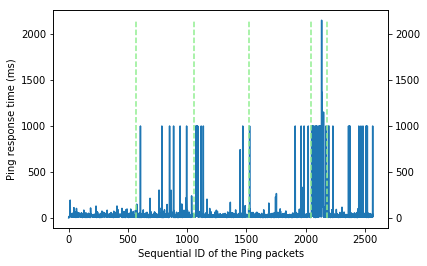

In [17]:
print(len(data), 'pings were sent.')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(data)
plt.xlabel('Sequential ID of the Ping packets')
plt.ylabel('Ping response time (ms)')
ax2 = ax.twinx()
ax2.vlines([565, 1060, 1525, 2045, 2180], ymin=min(data), ymax=max(data), colors="lightgreen", linestyles='dashed')
plt.show()

### 4.3. Time series pre-analysis
- We run a preliminary analysis of the obtained time series data.
- We can observe that our traffic speed data is slightly auto-correlated in the order of 3.

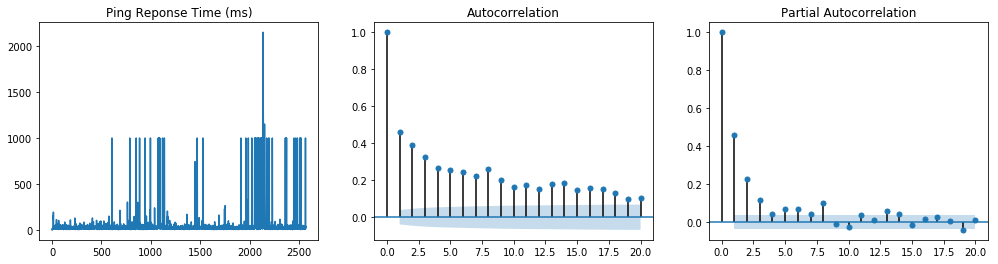

In [19]:
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
axes = ax.flatten()
diff_color = "#800000"

axes[0].plot(data)
axes[0].set_title("Ping Reponse Time (ms)")
fig = sm.graphics.tsa.plot_acf(data, lags=20, ax=axes[1])
fig = sm.graphics.tsa.plot_pacf(data, lags=20, ax=axes[2])

### 4.4. Change Point Detection

- Finally, we run the Change Point Detection method on the obtained data.
- <span style="color:blue">Blue</span> ping response time, <span style="color:red">Red</span>: detected change point scores, <span style="color:lightgreen">Green</span>: actual change points made by hand.
- By fine tuning the set of hyperparameters manually, we have found that {r=0.02, order=3, smooth=8} gives the best result for our data.

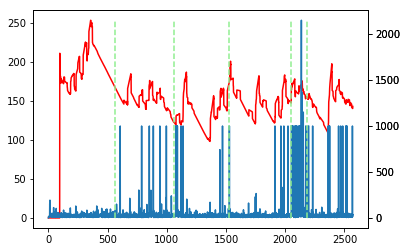

In [21]:
cf = changefinder.ChangeFinder(r=0.02, order=4, smooth=60)
 
ret = []
for i in data:
    score = cf.update(i)
    ret.append(score)
 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ret, 'r')
ax2 = ax.twinx()
ax2.plot(data)
ax3 = ax.twinx()
ax3.vlines([565, 1060, 1525, 2045, 2180], ymin=min(data), ymax=max(data), colors="lightgreen", linestyles='dashed')
plt.show()

## 5. Conclusion

- We have identified the change points correctly with a minor number of errors.
- For further development, change point can be detected online then alert it via Kibana (and email). To do this, calculating the outlier score with regular interval (e.g. 10 seconds) could be an option.
- It would also be interesting to change the traffic load in the network to make change points.
- There is also a possibility to fine tune the hyperparameters of the model based on the user's environment. Further empirical research with different kinds of environment could be a help to challenge the problem.

## Reference
1) Takeuchi, J., & Yamanishi, K. (2006). A unifying framework for detecting outliers and change points from time series. IEEE Transactions on Knowledge and Data Engineering, 18(4), 482-492. https://doi.org/10.1109/TKDE.2006.1599387.

2) https://speakerdeck.com/matsumoto_r/sdararugorizumutotong-ji-de-shou-fa-niyorushi-xi-lie-karafalsewai-rezhi-tobian-hua-dian-falsejian-chu?slide=37